# Neural Network from Scratch

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 

In [2]:
mu, sigma = 0, 0.1 # mean and standard deviation

In [3]:
# For the given mean and std, draw  1,000,000 random samples from −2𝜎, +2𝜎 to build a dataset
s = np.random.normal(mu, sigma, 1000000)

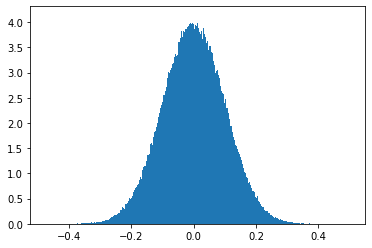

In [4]:
nbin = 1000
count, bins, ignored = plt.hist(s, nbin, density=True)

In [5]:
# Split the dataset into train (90%) and test(10%) 
x = np.asarray(bins[:-1])[..., np.newaxis]
y = np.asarray(count)[..., np.newaxis]
X = np.concatenate((x, y), axis=1)

In [6]:
np.random.shuffle(X)
slicesplit = int(0.9*nbin)
training, test = X[:slicesplit,:], X[slicesplit:,:]


In [7]:
# Using pure Python3 and Numpy, build a 3-layer neural networks:
# - Layers: {1 − 64 − 𝑅𝑒𝐿𝑈 − 64 − 𝑅𝑒𝐿𝑈 − 64 − 1 − 𝑠𝑖𝑔𝑚𝑜𝑖𝑑} 
# - Initialize the weights using a Gaussian distribution with zero mean and std=0.01.

In [8]:
# Class Definitions
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01*np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
    
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues) 
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)


class Activation_ReLU:
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
        
    def backward(self, dvalues):
        # Since we need to modify original variable, 
        # let's make a copy of values first 
        self.dinputs = dvalues.copy()
        # Zero gradient where input values were negative 
        self.dinputs[self.inputs <= 0] = 0


class Activation_Sigmoid:
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))
        
    def backward(self, dvalues):
    # Derivative - calculates from output of the sigmoid function 
        self.dinputs = dvalues*(1 - self.output)*self.output
    
    
class Loss:
    # Calculates the data losses 
    # given model output and ground truth values 
    def calculate(self, output, y):
        # Calculate sample losses 
        sample_losses = self.forward(output, y)
        # Calculate mean loss
        data_loss = np.mean(sample_losses)
        # Return loss 
        return data_loss
    

class Loss_MeanSquaredError(Loss): 
    # Mean Squared Error loss
    # Forward pass
    def forward(self, y_pred, y_true): # Calculate loss
        sample_losses = np.mean((y_true - y_pred)**2, axis=-1) 
        # Return losses
        return sample_losses
    
    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them 
        outputs = len(dvalues[0])
        
        # Gradient on values
        self.dinputs = -2*(y_true - dvalues)/outputs 
        # Normalize gradient
        self.dinputs = self.dinputs/samples

        
class Optimizer_SGD:
    # Initialize optimizer - set settings
    def __init__(self, learning_rate = 0.1): 
        self.learning_rate = learning_rate
    
    def update_params(self, layer):
        layer.weights += -self.learning_rate * layer.dweights
        layer.biases += -self.learning_rate * layer.dbiases


In [9]:
# Network Construction
dense1 = Layer_Dense(1, 64)
activation1 = Activation_ReLU()

dense2 = Layer_Dense(64, 64)
activation2 = Activation_ReLU()

dense3 = Layer_Dense(64, 1)
activation3 = Activation_Sigmoid() 

loss_function = Loss_MeanSquaredError()
optimizer = Optimizer_SGD(learning_rate = 0.1)

In [10]:
# Train for 20 epochs and evaluate the performance of your network
EPOCHS = 20

for epoch in range(EPOCHS): 
    
    # Training
    avetrainloss = []
    for row in training: #Batch size = 1
        X = row[0]
        y = row[1]
        
        # Forward pass
        dense1.forward(X)
        activation1.forward(dense1.output)

        dense2.forward(activation1.output)
        activation2.forward(dense2.output)

        dense3.forward(activation2.output)
        activation3.forward(dense3.output)

        trainloss = loss_function.calculate(activation3.output, y)

        # Backward pass 
        loss_function.backward(activation3.output, y)
        
        activation3.backward(loss_function.dinputs) 
        dense3.backward(activation3.dinputs) 
        
        activation2.backward(dense3.dinputs) 
        dense2.backward(activation2.dinputs) 
        
        activation1.backward(dense2.dinputs) 
        dense1.backward(activation1.dinputs)

        # Update weights and biases
        optimizer.update_params(dense1) 
        optimizer.update_params(dense2)
        optimizer.update_params(dense3)
        
        avetrainloss.append(trainloss)
    
    # Validation
    avetestloss = []
    for row in test:
        #Batch size = 1
        X = row[0]
        y = row[1]
        
        # Forward pass
        dense1.forward(X)
        activation1.forward(dense1.output)

        dense2.forward(activation1.output)
        activation2.forward(dense2.output)

        dense3.forward(activation2.output)
        activation3.forward(dense3.output)

        
        # Loss
        testloss = loss_function.calculate(activation3.output, y)
        
        avetestloss.append(testloss)
        
    print("Epoch: {}, Train loss: {}, Test loss {}".format(epoch,np.mean(avetrainloss),np.mean(avetestloss))) 



Epoch: 0, Train loss: 1.9185083589903889, Test loss 1.3953661006415012
Epoch: 1, Train loss: 1.8918284087842694, Test loss 1.4015183905253117


Epoch: 2, Train loss: 1.8897122266193558, Test loss 1.4042082279847485
Epoch: 3, Train loss: 1.8888549711550553, Test loss 1.4057315208647487


Epoch: 4, Train loss: 1.8883938351219562, Test loss 1.4067032612478336
Epoch: 5, Train loss: 1.8881099389457172, Test loss 1.4073689106089529


Epoch: 6, Train loss: 1.8879203003676241, Test loss 1.4078478209847478


Epoch: 7, Train loss: 1.8877862925411548, Test loss 1.4082052684958233
Epoch: 8, Train loss: 1.8876875653011451, Test loss 1.4084799279056244


Epoch: 9, Train loss: 1.887612429489505, Test loss 1.4086960404479258
Epoch: 10, Train loss: 1.8875537100290194, Test loss 1.40886941680104


Epoch: 11, Train loss: 1.8875068065010587, Test loss 1.4090108328503723
Epoch: 12, Train loss: 1.8874686700231784, Test loss 1.4091278831762337


Epoch: 13, Train loss: 1.88743716270679, Test loss 1.4092259444875195
Epoch: 14, Train loss: 1.8874107731047691, Test loss 1.4093089858398604


Epoch: 15, Train loss: 1.8873884018773748, Test loss 1.4093799469031427
Epoch: 16, Train loss: 1.887369239658176, Test loss 1.4094411343227484


Epoch: 17, Train loss: 1.8873526670202558, Test loss 1.4094942862658835


Epoch: 18, Train loss: 1.8873382134916794, Test loss 1.409540741426852


Epoch: 19, Train loss: 1.88732550621612, Test loss 1.4095815907530451
